In [83]:
# Necessary import statements
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
%matplotlib inline

In [84]:
# Set number of photons to simulate
num_photons = 100000

# Set attributes of plane-parallel atmosphere
rho = 1.6                                        # Average density of the Sun in g/cm^3
k = 0.14                                         # Average opacity of the Sun's photosphere in cm^2/g
tau_max = 10                                     # Optical depth of atmosphere (i.e. number of mean free paths)
z_max = tau_max/(rho*k)                          # Maximum height of atmosphere in centimeters

# Set number of slices of plane-parallel atmosphere
num_layers = 1000

# Initialize arrays for intensity moments
j_pos = np.zeros(num_layers)
j_neg = np.zeros(num_layers)
h_pos = np.zeros(num_layers)
h_neg = np.zeros(num_layers)
k_pos = np.zeros(num_layers)
k_neg = np.zeros(num_layers)

In [85]:
# Define necessary functions

def direction_cosines(theta, phi):
    """Converts given angles theta and phi into direction cosines."""
    
    # Implement formulas in spherical coordinates
    n_x = np.sin(theta)*np.cos(phi)
    n_y = np.sin(theta)*np.sin(phi)
    n_z = np.cos(theta)
    
    return np.array([n_x, n_y, n_z])

def calc_moments(old_z, new_z, mu):
    """Updates intensity moments after each photon movement."""
    
    # Case where photon moves upward
    if mu > 0 and abs(mu) > 0.001:
        
        # Calculate starting layer and end layer
        lower_bound = int((old_z/z_max)*num_layers)
        upper_bound = min(num_layers, int((new_z/z_max)*num_layers) + 1)
    
        # Update positive intensity moments
        for i in range(lower_bound, upper_bound):
            j_pos[i] += 1/mu
            h_pos[i] += 1
            k_pos[i] += mu
    
    # Case where photon moves downward
    elif mu < 0 and abs(mu) > 0.001:
        
        # Calculate starting layer and end layer
        lower_bound = max(0, int((new_z/z_max)*num_layers))
        upper_bound = int((old_z/z_max)*num_layers) + 1
        
        # Update negative intensity moments
        for i in range(lower_bound, upper_bound):
            j_neg[i] += 1/abs(mu)
            h_neg[i] += -1
            k_neg[i] += abs(mu)
    
    # Case where photon's z-coordinate remains the same
    else:
        lower_bound = int((new_z/z_max)*num_layers)
        upper_bound = lower_bound + 1
    
    return [lower_bound, upper_bound]

def launch_photon():
    """Emit a photon from the origin such that the flux is isotropic in all upward directions."""
    
    # Sample emission angles from a transformed distribution
    initial_theta = math.acos(np.sqrt(np.random.uniform()))
    initial_phi = 2*np.pi*np.random.uniform()
    
    # Compute initial direction cosines
    initial_dir_cos = direction_cosines(initial_theta, initial_phi)
    
    # Set initial position of the photon
    position = np.zeros(3)
    
    # Sample an optical depth from an exponential distribution
    tau = np.random.exponential()
    
    # Update the position of the photon
    distance = z_max*(tau/tau_max)
    position += distance*initial_dir_cos
    
    # Update intensity moment arrays
    calc_moments(position[2] - distance*np.cos(initial_theta), position[2], np.cos(initial_theta))
    
    return position

In [86]:
# Define storage arrays
final_ang = []
final_pos = []

# Keep track of number of re-emitted photons
returned_photons = 0

# Beginning of Monte Carlo Simulation
for counter in range(num_photons):

    # Inject a photon into the stellar atmosphere
    position = launch_photon()
    
    while position[2] <= z_max:         # Check to see if photon has escaped top of atmosphere
        
        # Determine scattering angles after collision event, assuming isotropic scattering
        new_theta = math.acos(2*np.random.uniform() - 1)
        new_phi = 2*np.pi*np.random.uniform()
        
        # Compute new direction cosines
        dir_cos = direction_cosines(new_theta, new_phi)
        
        # Sample a new optical depth from an exponential distribution
        new_tau = np.random.exponential()
    
        # Update the position of the photon
        new_distance = z_max*(new_tau/tau_max)
        position += new_distance*dir_cos
        
        # Update intensity moment arrays
        calc_moments(position[2] - new_distance*np.cos(new_theta), position[2], np.cos(new_theta))
        
        # Re-emit photon if it escapes bottom of atmosphere
        if position[2] < 0: 
            returned_photons += 1
            position = launch_photon()
    
    # Append final values to storage arrays
    final_ang.append([new_theta, new_phi])
    final_pos.append(position)
    
    # Keep track of how many photons have been simulated
    if (counter + 1) % 10000 == 0:
        print("{:5d} photons have been simulated!".format(counter + 1))

# Number of photons that returned to stellar interior
print('\n{:6d} photons returned to the stellar interior.'.format(returned_photons))

10000 photons have been simulated!
20000 photons have been simulated!
30000 photons have been simulated!
40000 photons have been simulated!
50000 photons have been simulated!
60000 photons have been simulated!
70000 photons have been simulated!
80000 photons have been simulated!
90000 photons have been simulated!
100000 photons have been simulated!

755855 photons returned to the stellar interior.


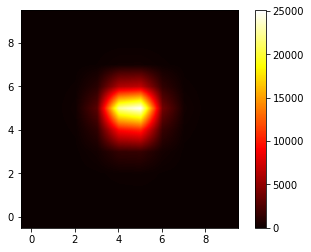

In [87]:
# Storage arrays for image coordinates
x = []
y = []

# Convert exit angles to image coordinates
for i in range(num_photons):
    ang = final_ang[i]
    pos = final_pos[i]
    x_image = pos[2]*np.sin(ang[0]) - pos[1]*np.cos(ang[0])*np.sin(ang[1]) - pos[0]*np.cos(ang[0])*np.cos(ang[1]) 
    y_image = pos[1]*np.cos(ang[1]) - pos[0]*np.sin(ang[1]) 
    x.append(x_image)
    y.append(y_image)

# Generate a 2-D array of counts
counts, x_edges, y_edges = np.histogram2d(x, y)

# Plot the 2-D array as a heatmap to create an image
plt.figure()
plt.imshow(counts, origin = 'low', interpolation = 'bilinear', cmap = 'hot')
plt.colorbar()
plt.show()

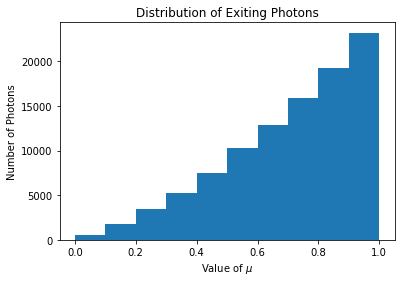

In [88]:
# Bin exiting photons based on cos(theta)
mu_vals = [np.cos(angle[0]) for angle in final_ang]
mu_counts, bin_edges, patches = plt.hist(mu_vals, range = (0, 1))

# Add information to histogram
plt.title('Distribution of Exiting Photons')
plt.xlabel('Value of $\mu$')
plt.ylabel('Number of Photons')
plt.show()

In [89]:
# Calculate mu value at middle of each bin
mu_loc = []
for i in range(len(mu_counts)):
    mu_loc.append(0.5*(bin_edges[i] + bin_edges[i+1]))
    
# Calculate normalized flux for each bin
fluxes = []
total_photons = sum(mu_counts)
for i in range(len(mu_counts)):
    fluxes.append(mu_counts[i]*len(mu_counts)/(2*total_photons*mu_loc[i]))

# Calculate error in normalized flux for each bin
errors = []
for i in range(len(fluxes)):
    errors.append(fluxes[i]/np.sqrt(mu_counts[i]))
    
print('Fluxes:\n', fluxes)
print('\nErrors:\n', errors)

Fluxes:
 [0.5360321619297157, 0.5720343220593235, 0.6910414624877492, 0.7439017769637607, 0.8321610407735575, 0.9360561633698021, 0.9892901266383674, 1.0619970531565228, 1.1354798934994923, 1.2213364380810219]

Errors:
 [0.023153062989359808, 0.013809038660458278, 0.011756555001048538, 0.010309125040804423, 0.009616022355261286, 0.00922502687904243, 0.00872374958025779, 0.008414514352407714, 0.008172939662587662, 0.008017775392557077]


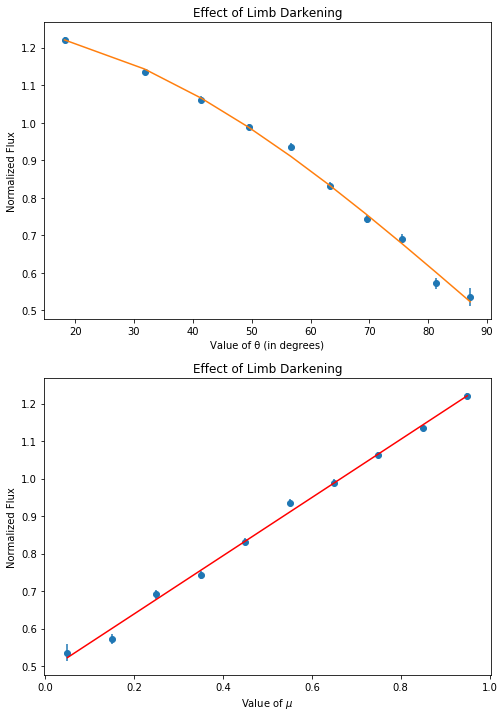

The best-fit line has equation y = 1.260 * (0.616x + 0.384).
The errors in the parameters are 0.0124 and 0.0082, respectively.


In [90]:
def lin_fitter(x, a, b):
    """Defines a general linear function."""
    return a*x + b

# Plot normalized flux vs. cos(theta)
plt.figure(figsize = (8, 12))
plt.subplot(212)
plt.scatter(mu_loc, fluxes)
plt.errorbar(mu_loc, fluxes, yerr = errors, ls = 'none')
plt.title('Effect of Limb Darkening')
plt.xlabel('Value of $\mu$')
plt.ylabel('Normalized Flux')

# Fit the scatter plot above to a linear function
p_0 = [0.6, 0.4]
params, cov = scipy.optimize.curve_fit(lin_fitter, mu_loc, fluxes, p_0, sigma = errors, absolute_sigma = True)

# Plot the fitted linear function over the data points
xfit = np.linspace(min(mu_loc),max(mu_loc),100)
plt.plot(xfit, lin_fitter(xfit, params[0], params[1]),'r-')

# Plot normalized flux vs. theta
degrees = np.arccos(mu_loc)*(180/np.pi)
plt.subplot(211)
plt.scatter(degrees, fluxes)
plt.errorbar(degrees, fluxes, yerr = errors, ls = 'none')
plt.title('Effect of Limb Darkening')
plt.xlabel('Value of θ (in degrees)')
plt.ylabel('Normalized Flux')

# Plot the corresponding cosine function
plt.plot(degrees, params[0]*np.cos(degrees*(np.pi/180)) + params[1])
plt.show()

# Result of simulation of limb-darkening phenomenon
coeff = fluxes[-1] + (1 - mu_loc[-1])*params[0]
slope = params[0]/coeff
intercept = params[1]/coeff
print("The best-fit line has equation y = {:4.3f} * ({:4.3f}x + {:4.3f}).".format(coeff, slope, intercept))
print("The errors in the parameters are {:5.4f} and {:5.4f}, respectively.".format(np.sqrt(cov[0][0]), np.sqrt(cov[1][1])))

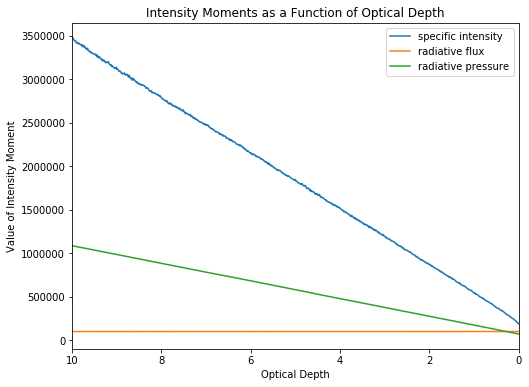

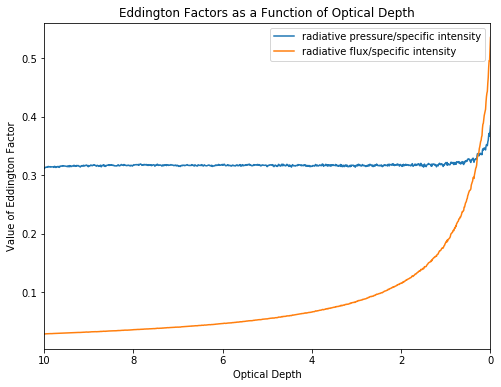

In [91]:
# Calculate total intensity moments as a function of layer
j = j_pos + j_neg
h = h_pos + h_neg
k = k_pos + k_neg

# Plot intensity moments as a function of optical depth
x_vals = [tau_max/num_layers*i for i in range(num_layers)][::-1]
plt.figure(figsize = (8, 6))
plt.plot(x_vals, j, label = 'specific intensity')
plt.plot(x_vals, h, label = 'radiative flux')
plt.plot(x_vals, k, label = 'radiative pressure')
plt.title('Intensity Moments as a Function of Optical Depth')
plt.xlabel('Optical Depth')
plt.ylabel('Value of Intensity Moment')
plt.xlim(10, 0)
plt.legend()

# Compute Eddington factors as a function of optical depth
f = np.divide(k, j)
g = np.divide(h, j)

# Plot Eddington factors as a function of optical depth
plt.figure(figsize = (8, 6))
plt.plot(x_vals, f, label = 'radiative pressure/specific intensity')
plt.plot(x_vals, g, label = 'radiative flux/specific intensity')
plt.title('Eddington Factors as a Function of Optical Depth')
plt.xlabel('Optical Depth')
plt.ylabel('Value of Eddington Factor')
plt.legend()
plt.xlim(10, 0)
plt.show()

In [92]:
print(f[0])

0.311771443264504
